Added on to Pooja's code to understand if there is some signifiance between clusters and type of tumor (metastasis versus primary)

In [ ]:
# Author: adyant
# GPT used for understanding packages and help with organizing code for tests, debugging

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from scipy.stats import chi2_contingency


In [ ]:
import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [ ]:
# Load DeepMHC data for neoantigen HLA binders and SCLC subtype label
'''
data format: rows = patients, columns = genes
data file names indicate binding for HLA A, HLA B, and both HLA A and HLA B
'''
# paths to data generated from DeepMHCi, 0.1
data_hla_A_1 = pd.read_csv('/content/drive/Shareddrives/BMI212/Analysis/results_Jun/gene_counts_per_sample_deepmhci_SCLC_0.1_A.csv', header=0, index_col=0)
data_hla_B_1 = pd.read_csv('/content/drive/Shareddrives/BMI212/Analysis/results_Jun/gene_counts_per_sample_deepmhci_SCLC_0.1_B.csv', header=0, index_col=0)
data_hla_AB_1 = pd.read_csv('/content/drive/Shareddrives/BMI212/Analysis/results_Jun/gene_counts_per_sample_deepmhci_SCLC_limit=1_combined.csv', header=0, index_col=0)

# paths to data generated from DeepMHCi, 0.2
data_hla_A_2 = pd.read_csv('/content/drive/Shareddrives/BMI212/Analysis/results_Jun/gene_counts_per_sample_deepmhci_SCLC_0.2_A.csv', header=0, index_col=0)
data_hla_B_2 = pd.read_csv('/content/drive/Shareddrives/BMI212/Analysis/results_Jun/gene_counts_per_sample_deepmhci_SCLC_0.2_B.csv', header=0, index_col=0)
data_hla_AB_2 = pd.read_csv('/content/drive/Shareddrives/BMI212/Analysis/results_Jun/gene_counts_per_sample_deepmhci_SCLC_limit=2_combined.csv', header=0, index_col=0)

# subtype labels (for supervised clustering)
subtype_path = "/content/drive/Shareddrives/BMI212/AIM2/subtype_mapping.xlsx"
subtype_df = pd.read_excel(subtype_path, index_col=0, header=0)
subtype_df = subtype_df[subtype_df['Subtype'].notna()]
subtype_df.index = subtype_df.index.str.replace(r'_.*$', '', regex=True)

In [ ]:
# data_names = ['HLA-A', 'HLA-B', 'HLA-A and HLA-B']
# data = [data_hla_A, data_hla_B, data_hla_AB]
data_names_1 = ['SCLC: HLA-A, 0.1', 'SCLC: HLA-B, 0.1', 'SCLC: Combined, 0.1']
data_1 = [data_hla_A_1, data_hla_B_1, data_hla_AB_1]

for data, name in zip(data_1, data_names_1):
  print(f"{name}: {data.shape}")

SCLC: HLA-A, 0.1: (47, 12150)
SCLC: HLA-B, 0.1: (47, 12150)
SCLC: Combined, 0.1: (47, 12150)


In [ ]:
data_names_2 = ['SCLC: HLA-A, 0.2', 'SCLC: HLA-B, 0.2', 'SCLC: Combined, 0.2']
data_2 = [data_hla_A_2, data_hla_B_2, data_hla_AB_2]

for data, name in zip(data_2, data_names_2):
  print(f"{name}: {data.shape}")

SCLC: HLA-A, 0.2: (47, 12150)
SCLC: HLA-B, 0.2: (47, 12150)
SCLC: Combined, 0.2: (47, 12150)


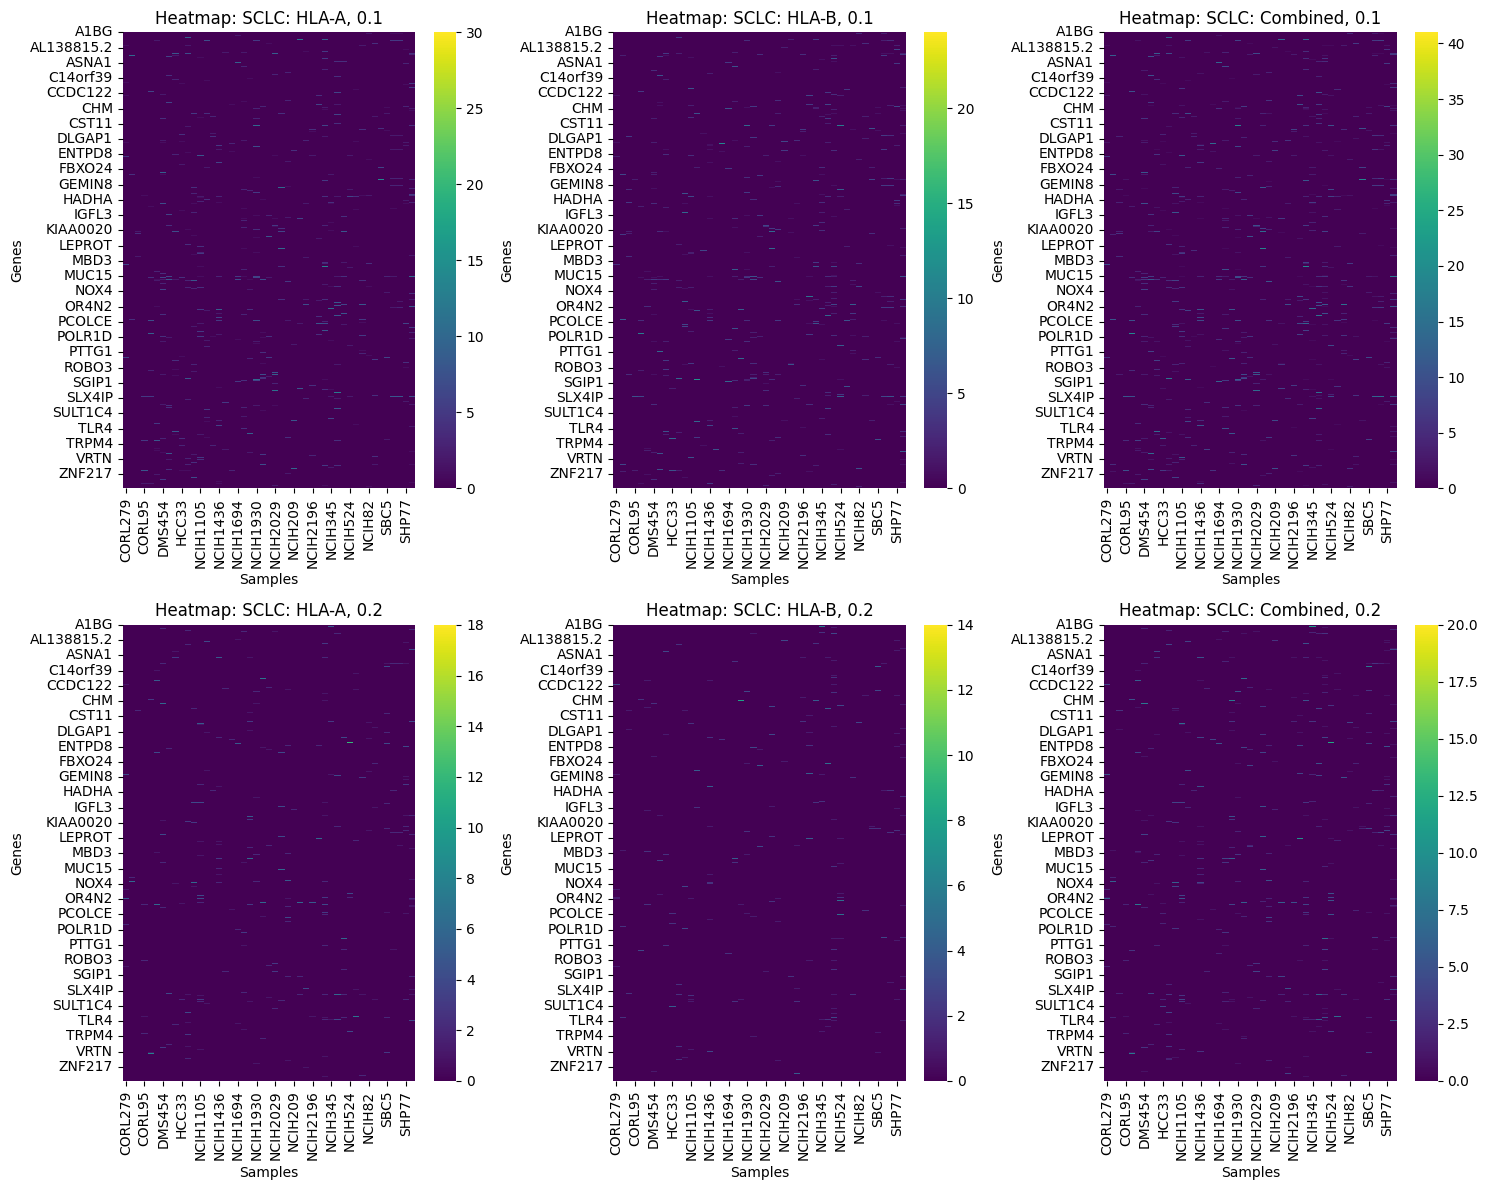

In [ ]:
n_cols = max(len(data_1), len(data_2))

fig, axes = plt.subplots(2, n_cols, figsize=(5 * n_cols, 12))

# Plot heatmaps for data_1 (binding affinity 0.1)
for idx, (data, name) in enumerate(zip(data_1, data_names_1)):
    ax = axes[0, idx]
    sns.heatmap(data.T, cmap="viridis", ax=ax)
    ax.set_title(f'Heatmap: {name}')
    ax.set_xlabel('Samples')
    ax.set_ylabel('Genes')

# Plot heatmaps for data_2 (binding affinity 0.2)
for idx, (data, name) in enumerate(zip(data_2, data_names_2)):
    ax = axes[1, idx]
    sns.heatmap(data.T, cmap="viridis", ax=ax)
    ax.set_title(f'Heatmap: {name}')
    ax.set_xlabel('Samples')
    ax.set_ylabel('Genes')

plt.tight_layout()
plt.show()


In [ ]:
# Function to run LDA supervised clustering
def run_supervised_clustering(data, subtype_df, dataset_name="Dataset"):
    # Align samples
    data = data.loc[data.index.intersection(subtype_df.index)]
    subtypes = subtype_df.loc[data.index]

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    # LDA (Supervised projection)
    lda = LDA(n_components=2)  # 2 components for visualization
    X_lda = lda.fit_transform(X_scaled, subtypes['Subtype'])

    # Clustering (KMeans)
    n_clusters = subtypes['Subtype'].nunique()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_lda)

    # Evaluation
    ari = adjusted_rand_score(subtypes['Subtype'], kmeans_labels)
    nmi = normalized_mutual_info_score(subtypes['Subtype'], kmeans_labels)

    print(f"{dataset_name}:")
    print(f"  ARI: {ari:.3f}")
    print(f"  NMI: {nmi:.3f}")

    # Visualization
    plt.figure(figsize=(12, 5))

    # True Subtypes
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=subtypes['Subtype'], palette='tab10')
    plt.title(f'{dataset_name} - True Subtypes (LDA Projection)')
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # KMeans Clusters
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=kmeans_labels, palette='Set2')
    plt.title(f'{dataset_name} - KMeans Clusters (LDA Projection)')
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.tight_layout()
    plt.show()

In [ ]:
print("Gene Count Matrix (data_hla_A_1) Index:")
print(data_hla_A_1.index[:5].tolist())

print("\nSubtype Mapping (subtype_df) Index:")
print(subtype_df.index[:5].tolist())

Gene Count Matrix (data_hla_A_1) Index:
['CORL279', 'CORL47', 'CORL88', 'CORL95', 'CPCN']

Subtype Mapping (subtype_df) Index:
['CORL279', 'CORL47', 'CORL88', 'CORL95', 'HCC33']


DeepMHC 0.1 HLA-A:
  ARI: 0.133
  NMI: 0.253


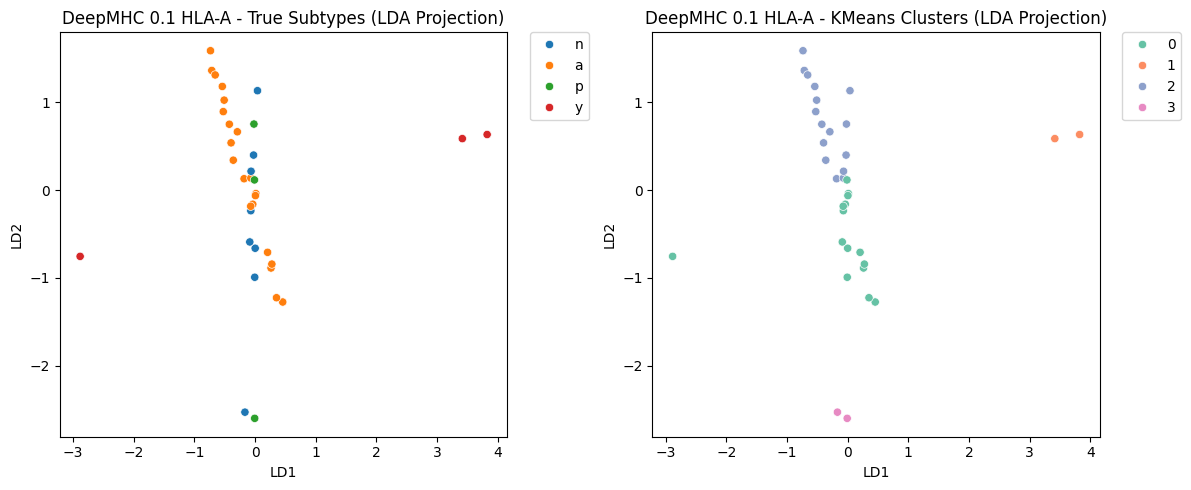

DeepMHC 0.1 HLA-B:
  ARI: 0.066
  NMI: 0.272


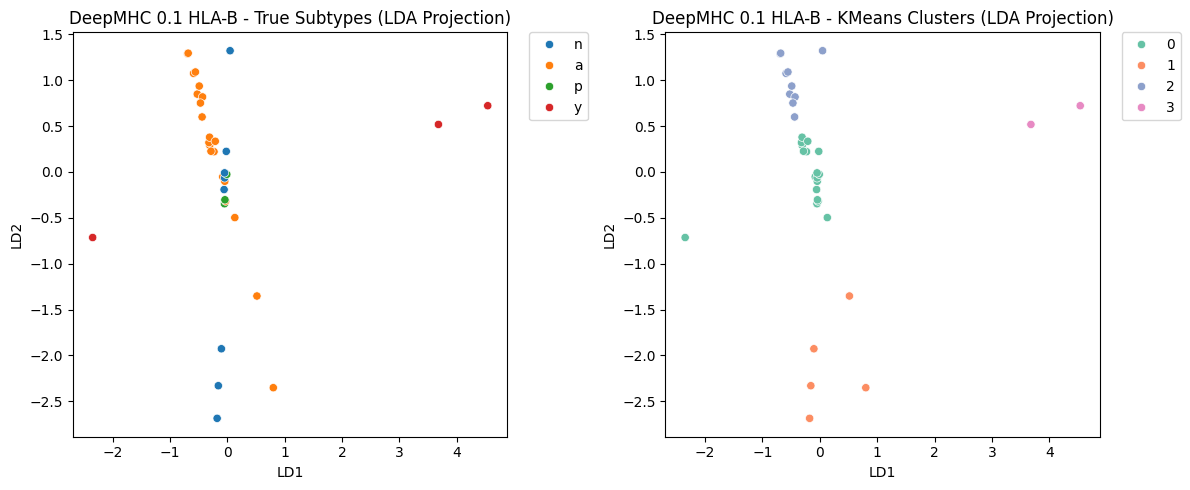

DeepMHC 0.1 HLA-AB:
  ARI: 0.180
  NMI: 0.356


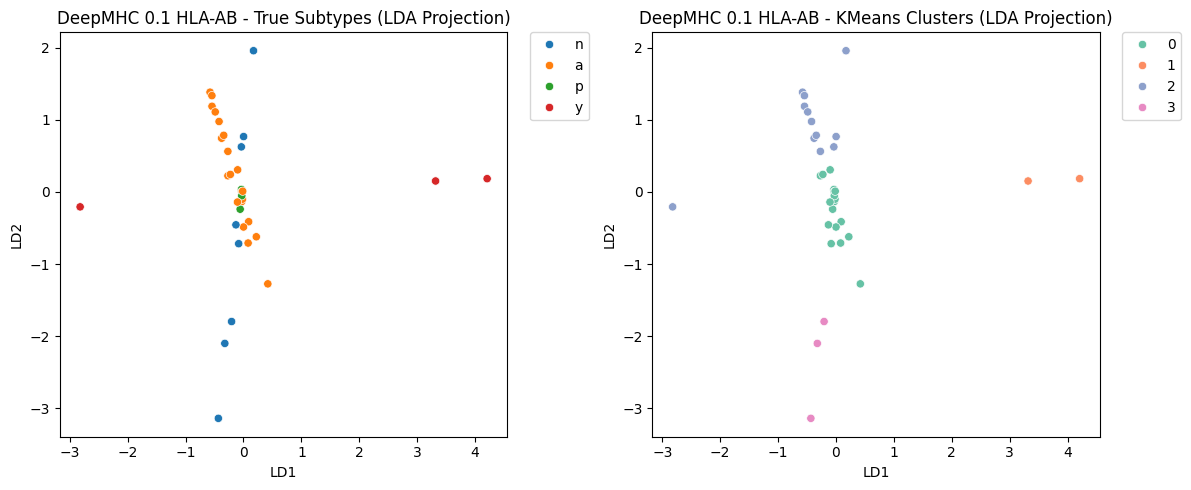

In [ ]:
# Run LDA supervised clustering on 0.1 binding
run_supervised_clustering(data_hla_A_1, subtype_df, dataset_name="DeepMHC 0.1 HLA-A")
run_supervised_clustering(data_hla_B_1, subtype_df, dataset_name="DeepMHC 0.1 HLA-B")
run_supervised_clustering(data_hla_AB_1, subtype_df, dataset_name="DeepMHC 0.1 HLA-AB")

DeepMHC 0.2 HLA-A:
  ARI: 0.077
  NMI: 0.282


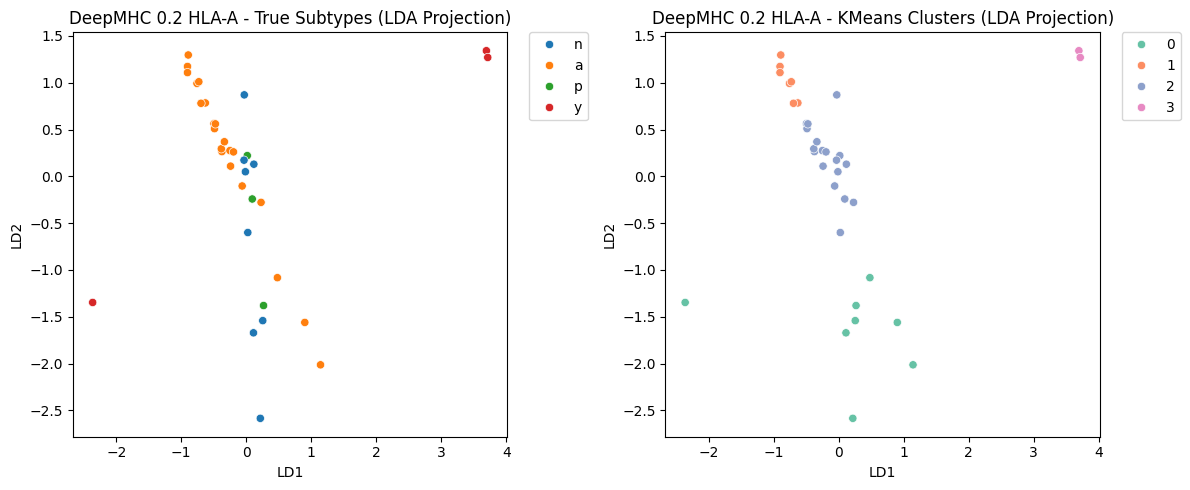

DeepMHC 0.2 HLA-B:
  ARI: 0.464
  NMI: 0.447


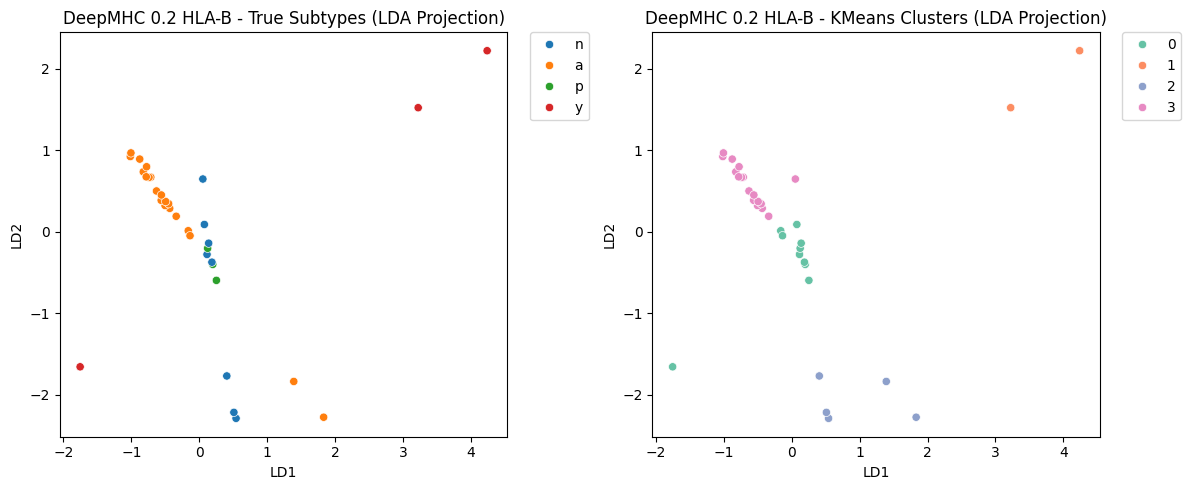

DeepMHC 0.2 HLA-AB:
  ARI: 0.151
  NMI: 0.313


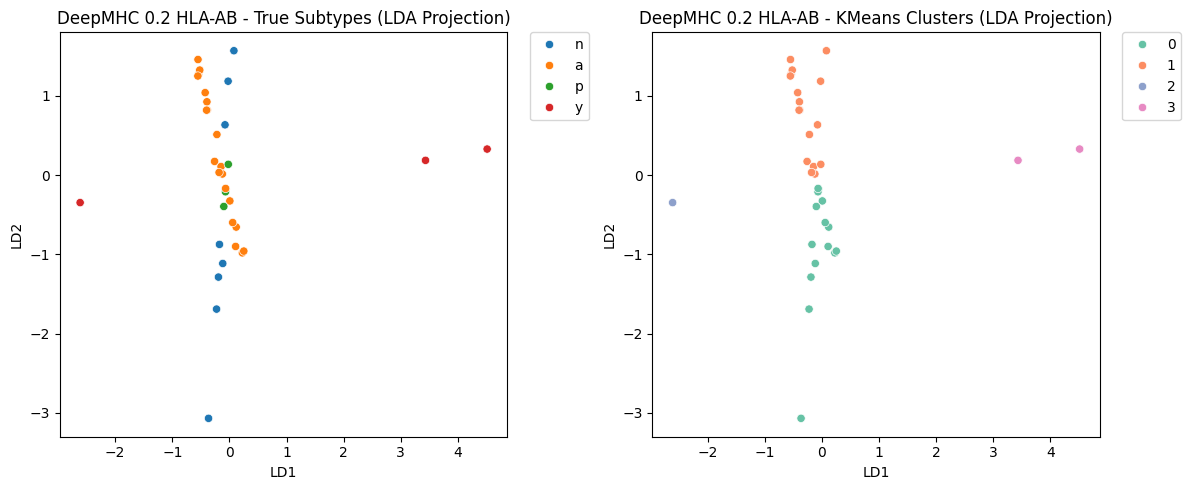

In [ ]:
# Run LDA supervised clustering on 0.2 binding
run_supervised_clustering(data_hla_A_2, subtype_df, dataset_name="DeepMHC 0.2 HLA-A")
run_supervised_clustering(data_hla_B_2, subtype_df, dataset_name="DeepMHC 0.2 HLA-B")
run_supervised_clustering(data_hla_AB_2, subtype_df, dataset_name="DeepMHC 0.2 HLA-AB")

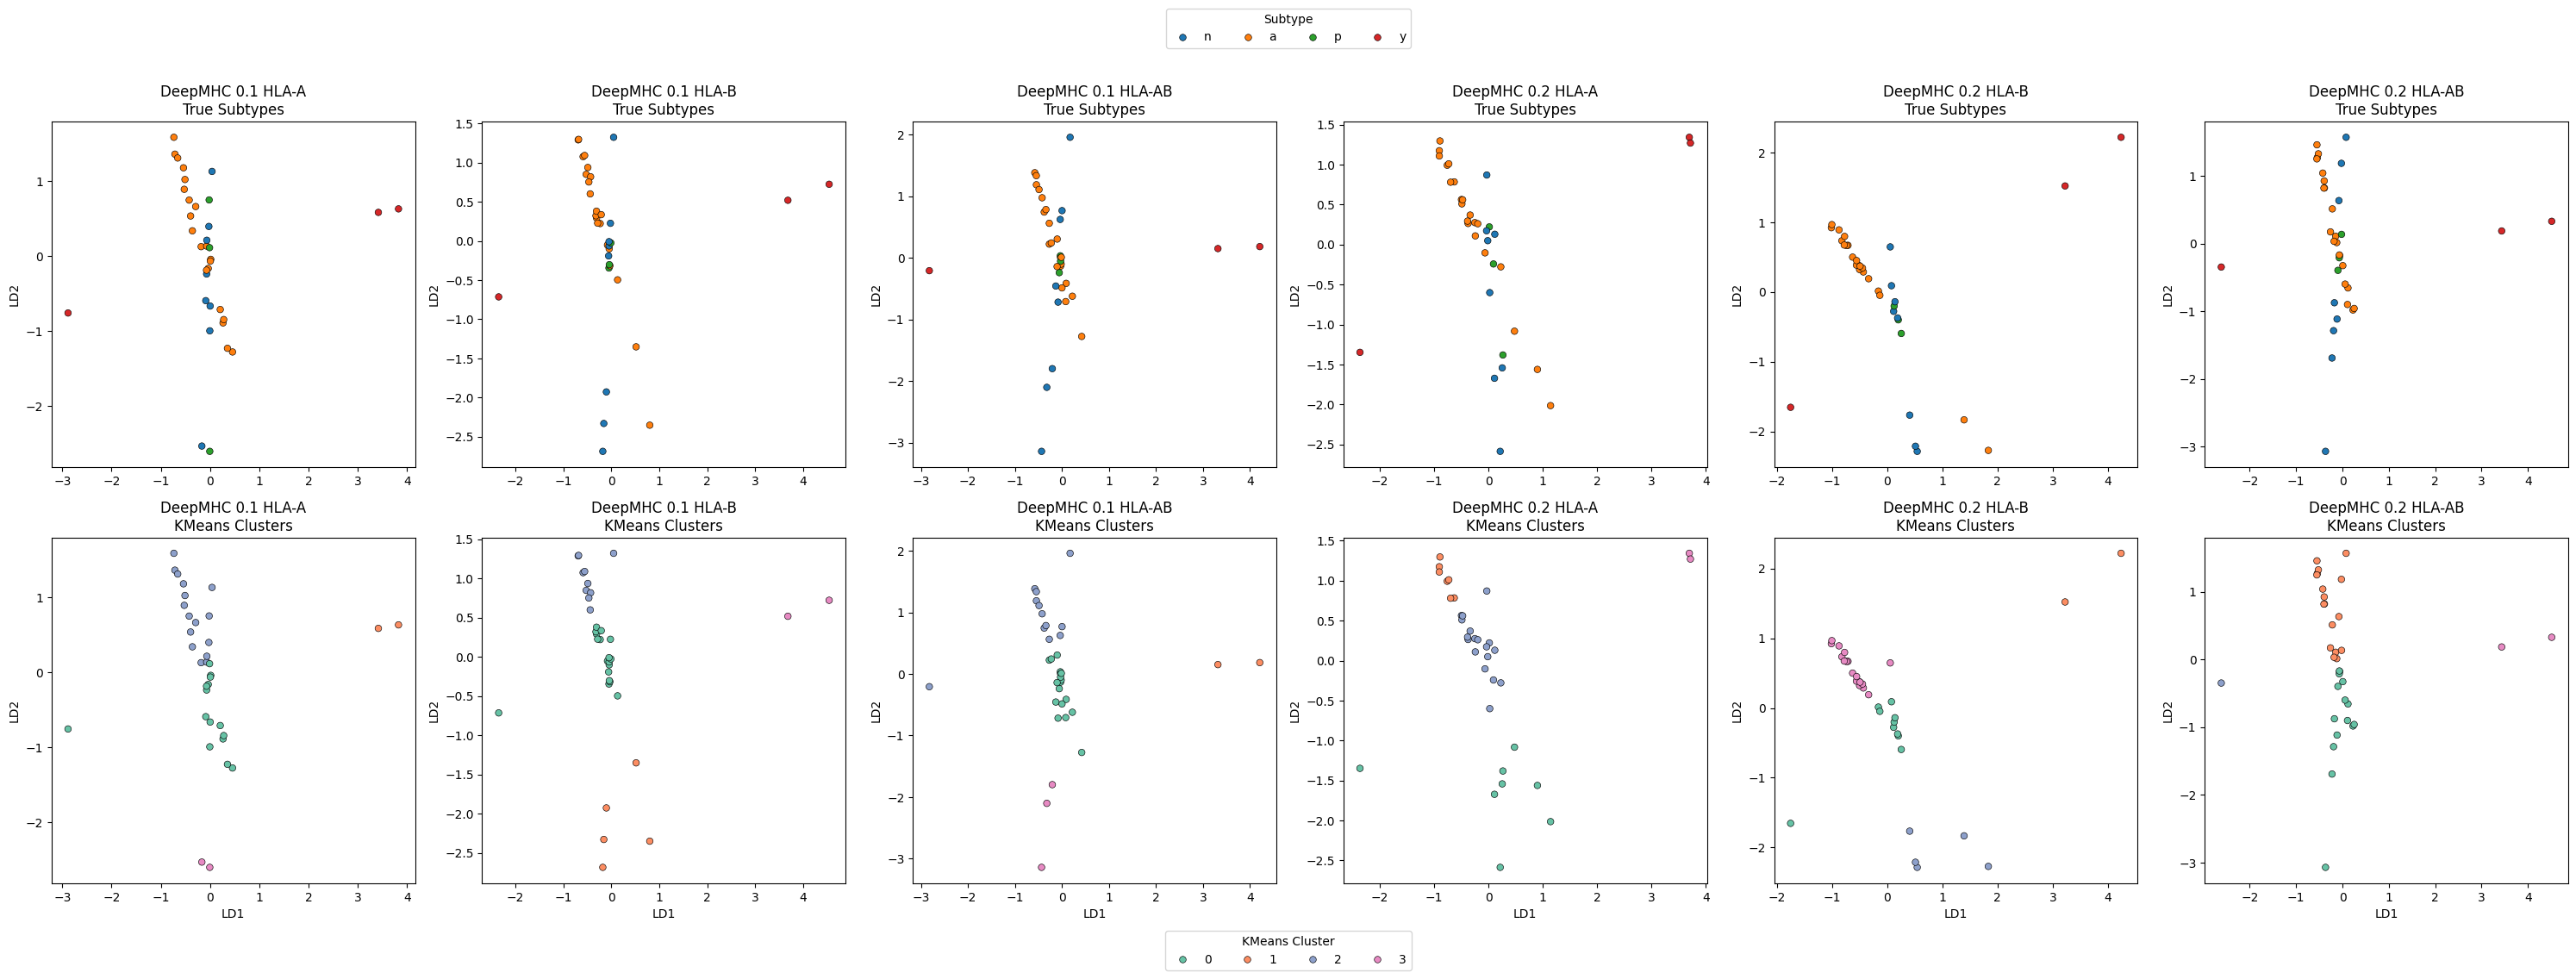

In [ ]:
# Plot for publication
def lda_kmeans_project(data, subtypes):
    data.index = data.index.str.strip().str.upper()
    common_samples = data.index.intersection(subtypes.index)
    data = data.loc[common_samples]
    subtypes = subtypes.loc[common_samples]

    subtypes = subtypes[subtypes['Subtype'].notna()]
    subtypes = subtypes[subtypes['Subtype'].str.strip() != '']
    data = data.loc[subtypes.index]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    lda = LDA(n_components=2)
    X_lda = lda.fit_transform(X_scaled, subtypes['Subtype'])

    n_clusters = subtypes['Subtype'].nunique()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_lda)

    return X_lda, subtypes['Subtype'], kmeans_labels

# -- Prepare the datasets --
datasets = [
    (data_hla_A_1, "DeepMHC 0.1 HLA-A"),
    (data_hla_B_1, "DeepMHC 0.1 HLA-B"),
    (data_hla_AB_1, "DeepMHC 0.1 HLA-AB"),
    (data_hla_A_2, "DeepMHC 0.2 HLA-A"),
    (data_hla_B_2, "DeepMHC 0.2 HLA-B"),
    (data_hla_AB_2, "DeepMHC 0.2 HLA-AB"),
]

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(30, 10))  # 2 rows, 6 columns

# -- For collecting handles/labels --
handles_top = []
labels_top = []
handles_bottom = []
labels_bottom = []

for i, (data, name) in enumerate(datasets):
    X_lda, true_labels, kmeans_labels = lda_kmeans_project(data, subtype_df)

    # Top row: True Subtypes
    sns.scatterplot(ax=axes[0, i], x=X_lda[:, 0], y=X_lda[:, 1], hue=true_labels, palette='tab10', s=30, edgecolor='k')
    axes[0, i].set_title(f"{name}\nTrue Subtypes")
    axes[0, i].set_xlabel('')
    axes[0, i].set_ylabel('LD2')

    if i == 0:  # Capture legend only once
        handles_top, labels_top = axes[0, i].get_legend_handles_labels()

    axes[0, i].legend_.remove()

    # Bottom row: KMeans Clusters
    sns.scatterplot(ax=axes[1, i], x=X_lda[:, 0], y=X_lda[:, 1], hue=kmeans_labels, palette='Set2', s=30, edgecolor='k')
    axes[1, i].set_title(f"{name}\nKMeans Clusters")
    axes[1, i].set_xlabel('LD1')
    axes[1, i].set_ylabel('LD2')

    if i == 0:  # Capture legend only once
        handles_bottom, labels_bottom = axes[1, i].get_legend_handles_labels()

    axes[1, i].legend_.remove()

# -- Add shared legends --
fig.legend(handles_top, labels_top, title="Subtype", loc='upper center', ncol=len(labels_top), bbox_to_anchor=(0.5, 1.08))
fig.legend(handles_bottom, labels_bottom, title="KMeans Cluster", loc='lower center', ncol=len(labels_bottom), bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()

In [ ]:
# Define projection functions
def project_data(method, data, subtypes):
    data.index = data.index.str.strip().str.upper()
    common_samples = data.index.intersection(subtypes.index)
    data = data.loc[common_samples]
    subtypes = subtypes.loc[common_samples]

    subtypes = subtypes[subtypes['Subtype'].notna()]
    subtypes = subtypes[subtypes['Subtype'].str.strip() != '']
    data = data.loc[subtypes.index]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    if method == 'pca':
        reducer = PCA(n_components=2)
        X_proj = reducer.fit_transform(X_scaled)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=42)
        X_proj = reducer.fit_transform(X_scaled)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        X_proj = reducer.fit_transform(X_scaled)
    else:
        raise ValueError("Unsupported method: choose 'pca', 'umap', or 'tsne'")

    n_clusters = subtypes['Subtype'].nunique()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_proj)

    return X_proj, subtypes['Subtype'], kmeans_labels

# List of datasets
datasets = [
    (data_hla_A_1, "DeepMHC 0.1 HLA-A"),
    (data_hla_B_1, "DeepMHC 0.1 HLA-B"),
    (data_hla_AB_1, "DeepMHC 0.1 HLA-AB"),
    (data_hla_A_2, "DeepMHC 0.2 HLA-A"),
    (data_hla_B_2, "DeepMHC 0.2 HLA-B"),
    (data_hla_AB_2, "DeepMHC 0.2 HLA-AB"),
]


In [ ]:
# 2x6 Grid for a given method (PCA / UMAP / t-SNE) --
def plot_grid(method_name):
    fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(30, 10))
    handles_top, labels_top = [], []
    handles_bottom, labels_bottom = [], []

    for i, (data, name) in enumerate(datasets):
        X_proj, true_labels, kmeans_labels = project_data(method_name, data, subtype_df)

        # Top: True Subtypes
        sns.scatterplot(ax=axes[0, i], x=X_proj[:, 0], y=X_proj[:, 1], hue=true_labels, palette='tab10', s=30, edgecolor='k')
        axes[0, i].set_title(f"{name}\nTrue Subtypes")
        axes[0, i].set_xlabel('')
        axes[0, i].set_ylabel('Dim 2')

        if i == 0:
            handles_top, labels_top = axes[0, i].get_legend_handles_labels()

        axes[0, i].legend_.remove()

        # Bottom: KMeans Clusters
        sns.scatterplot(ax=axes[1, i], x=X_proj[:, 0], y=X_proj[:, 1], hue=kmeans_labels, palette='Set2', s=30, edgecolor='k')
        axes[1, i].set_title(f"{name}\nKMeans Clusters")
        axes[1, i].set_xlabel('Dim 1')
        axes[1, i].set_ylabel('Dim 2')

        if i == 0:
            handles_bottom, labels_bottom = axes[1, i].get_legend_handles_labels()

        axes[1, i].legend_.remove()

    # Global legends
    fig.legend(handles_top, labels_top, title="Subtype", loc='upper center', ncol=len(labels_top), bbox_to_anchor=(0.5, 1.08))
    fig.legend(handles_bottom, labels_bottom, title="KMeans Cluster", loc='lower center', ncol=len(labels_bottom), bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout()
    plt.show()
    # Save the figure
    fig.savefig(f"projection_grid_{method_name}.png", dpi=300, bbox_inches='tight')


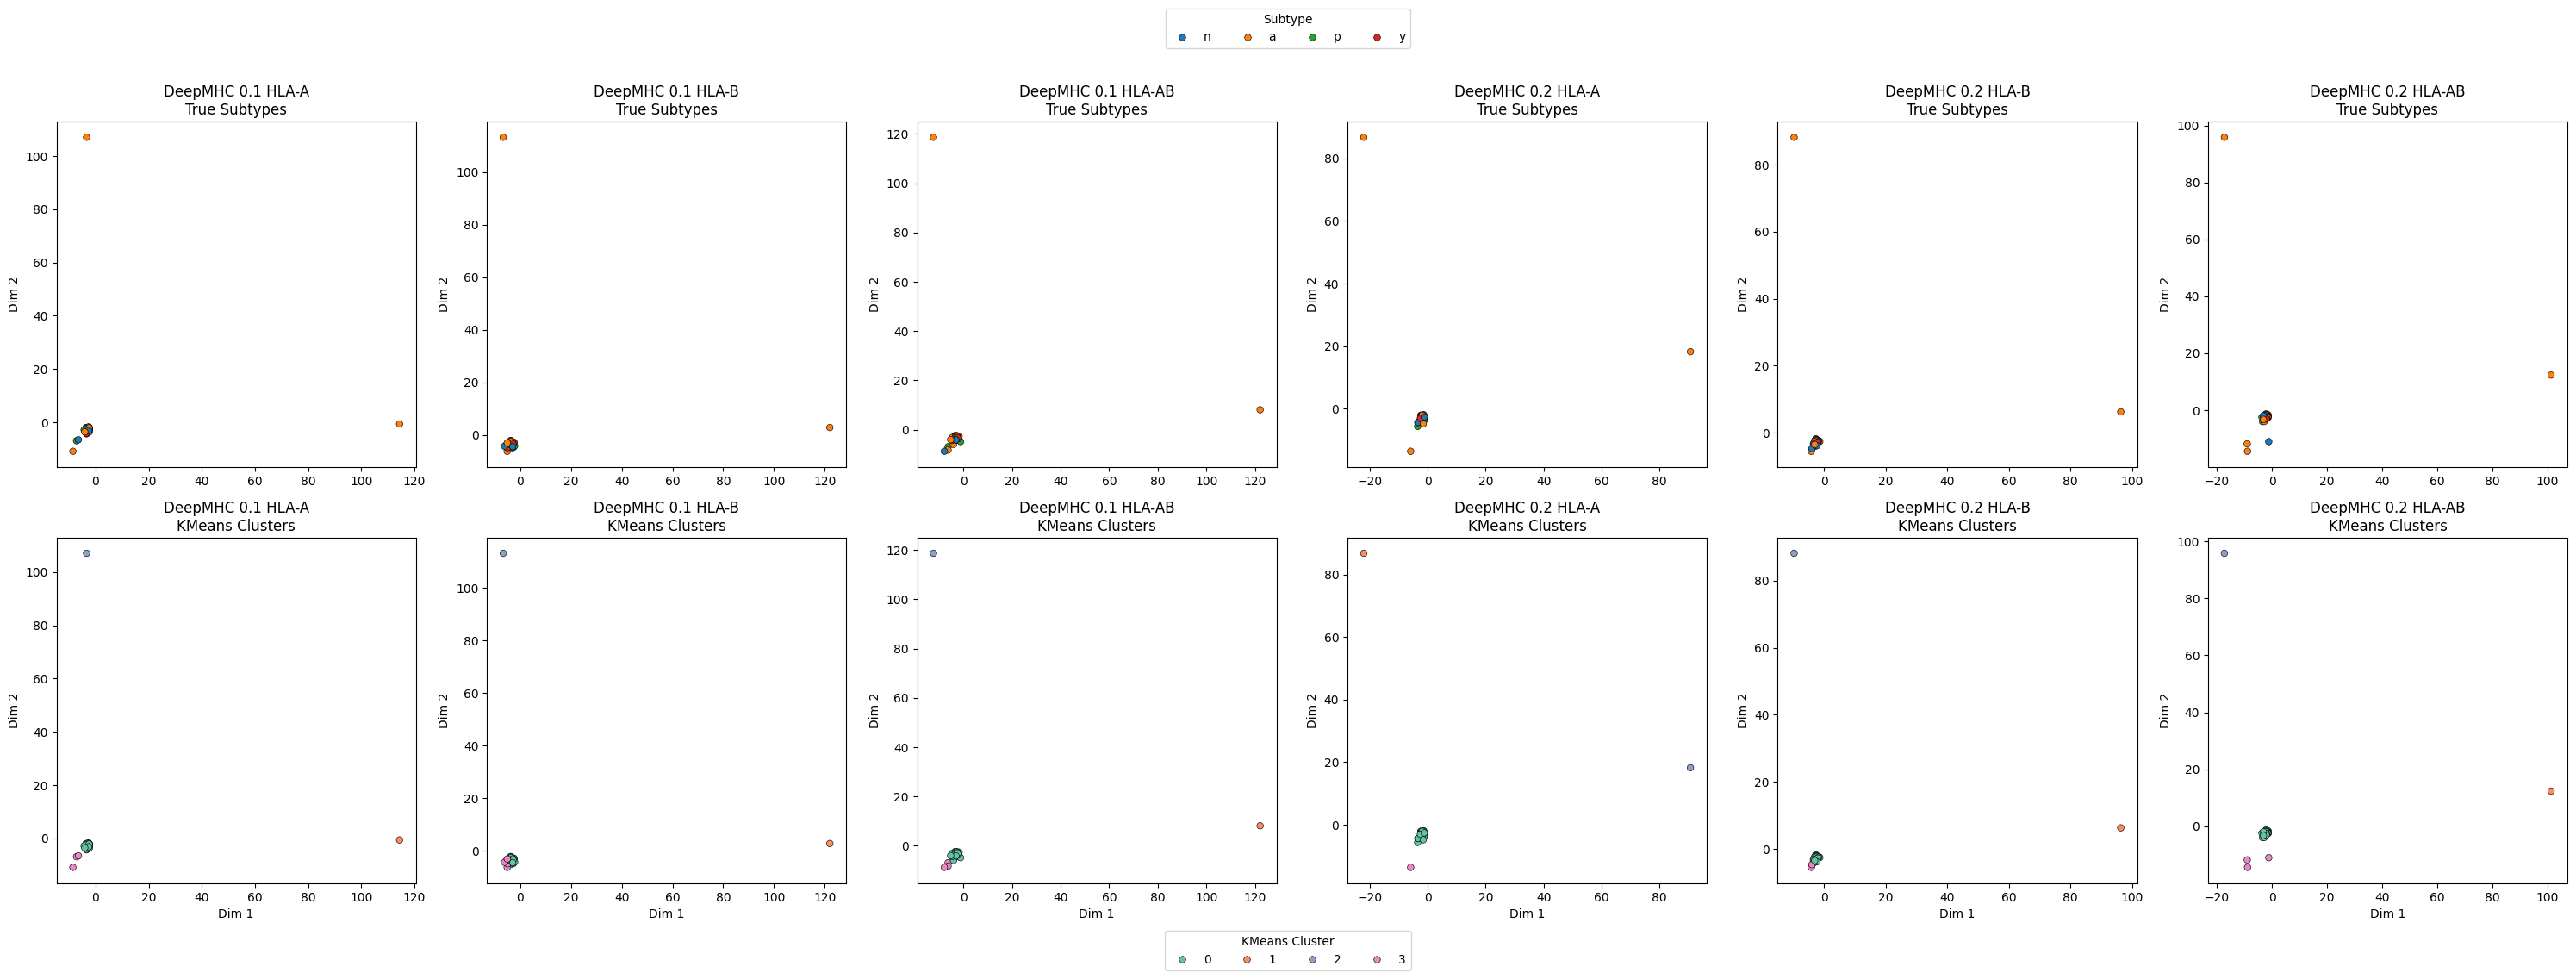

In [ ]:
plot_grid('pca')


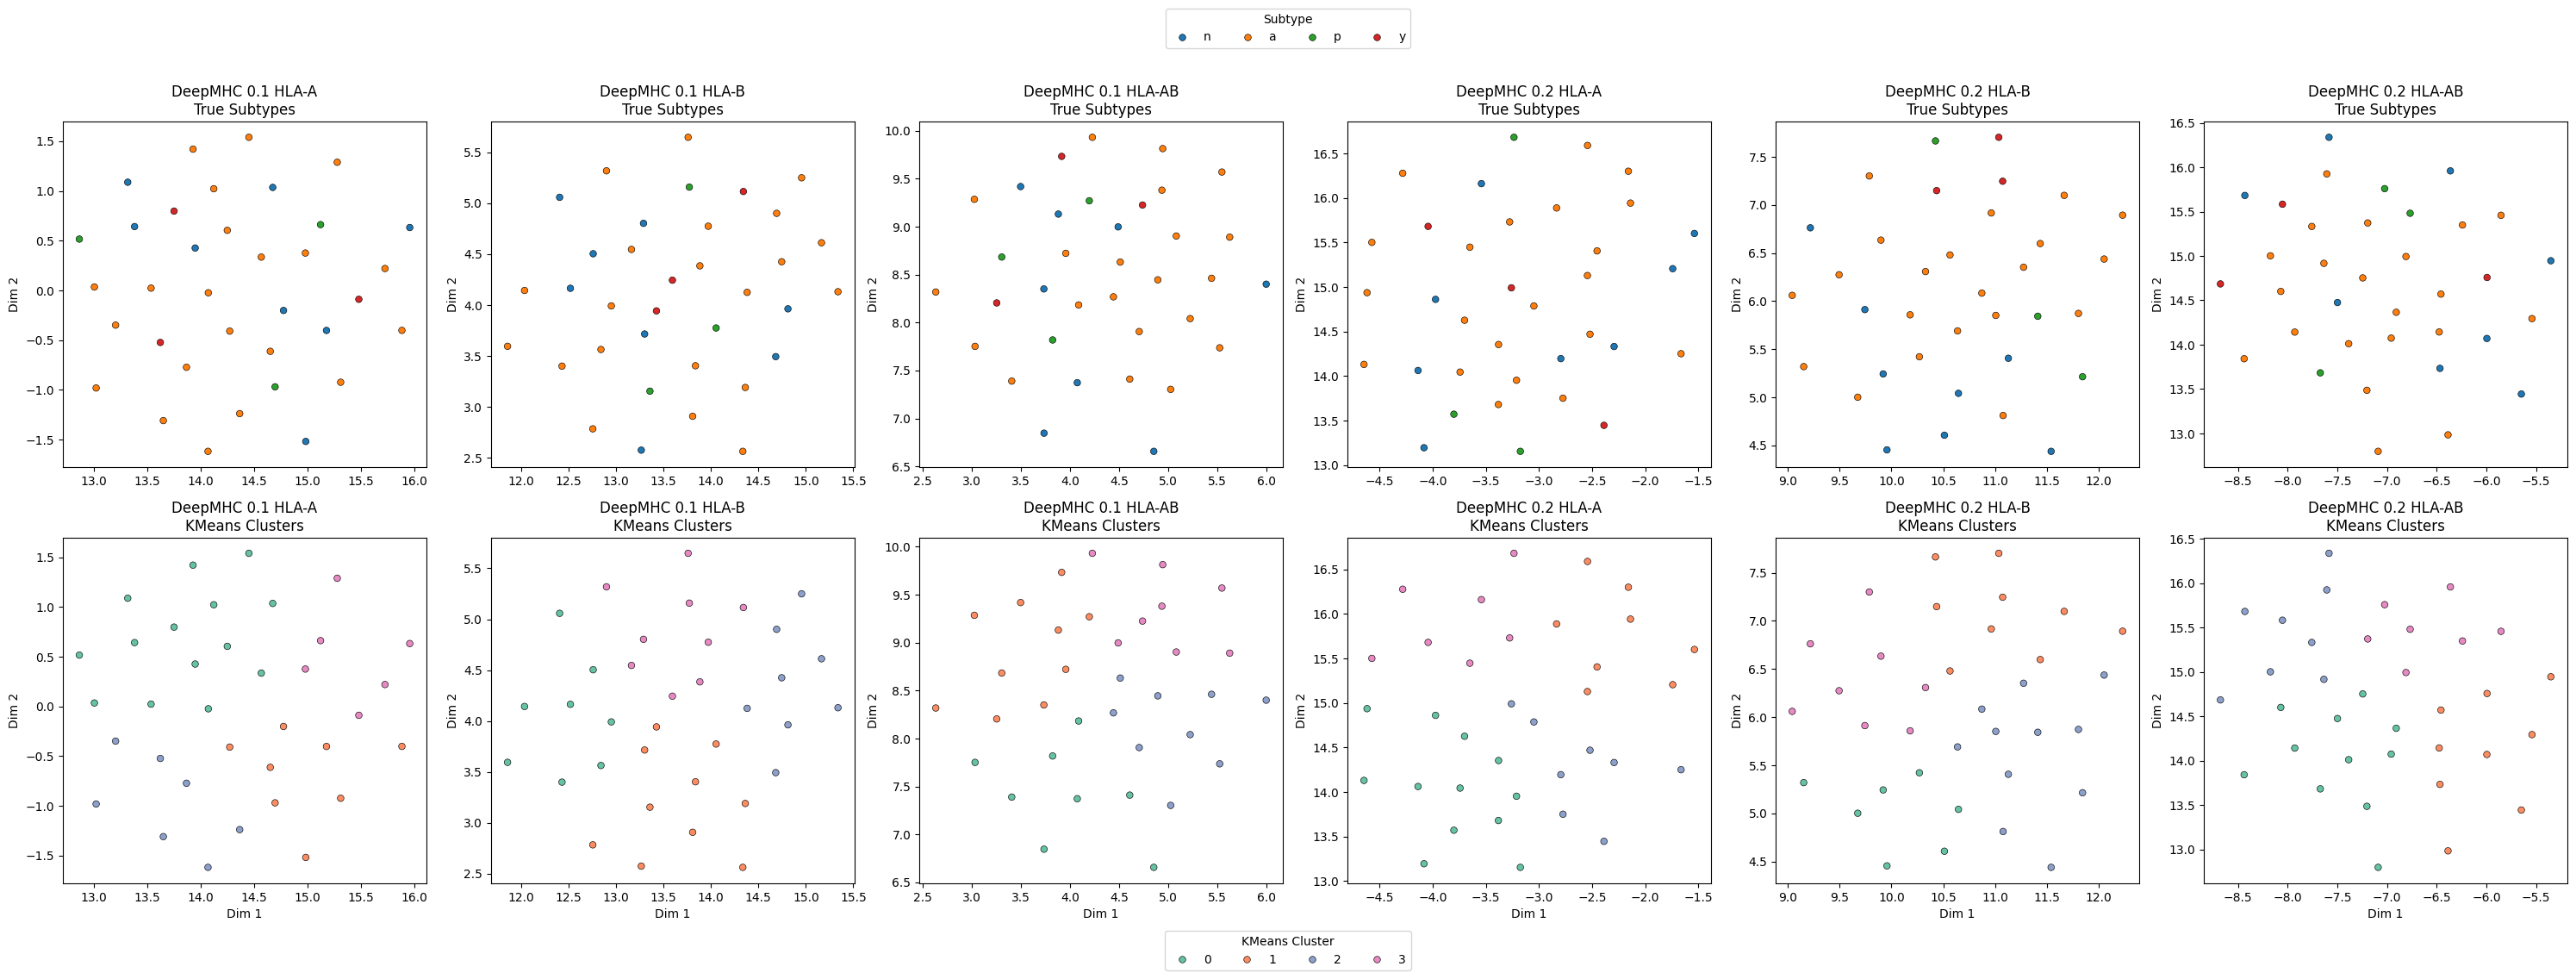

In [ ]:
plot_grid('umap')


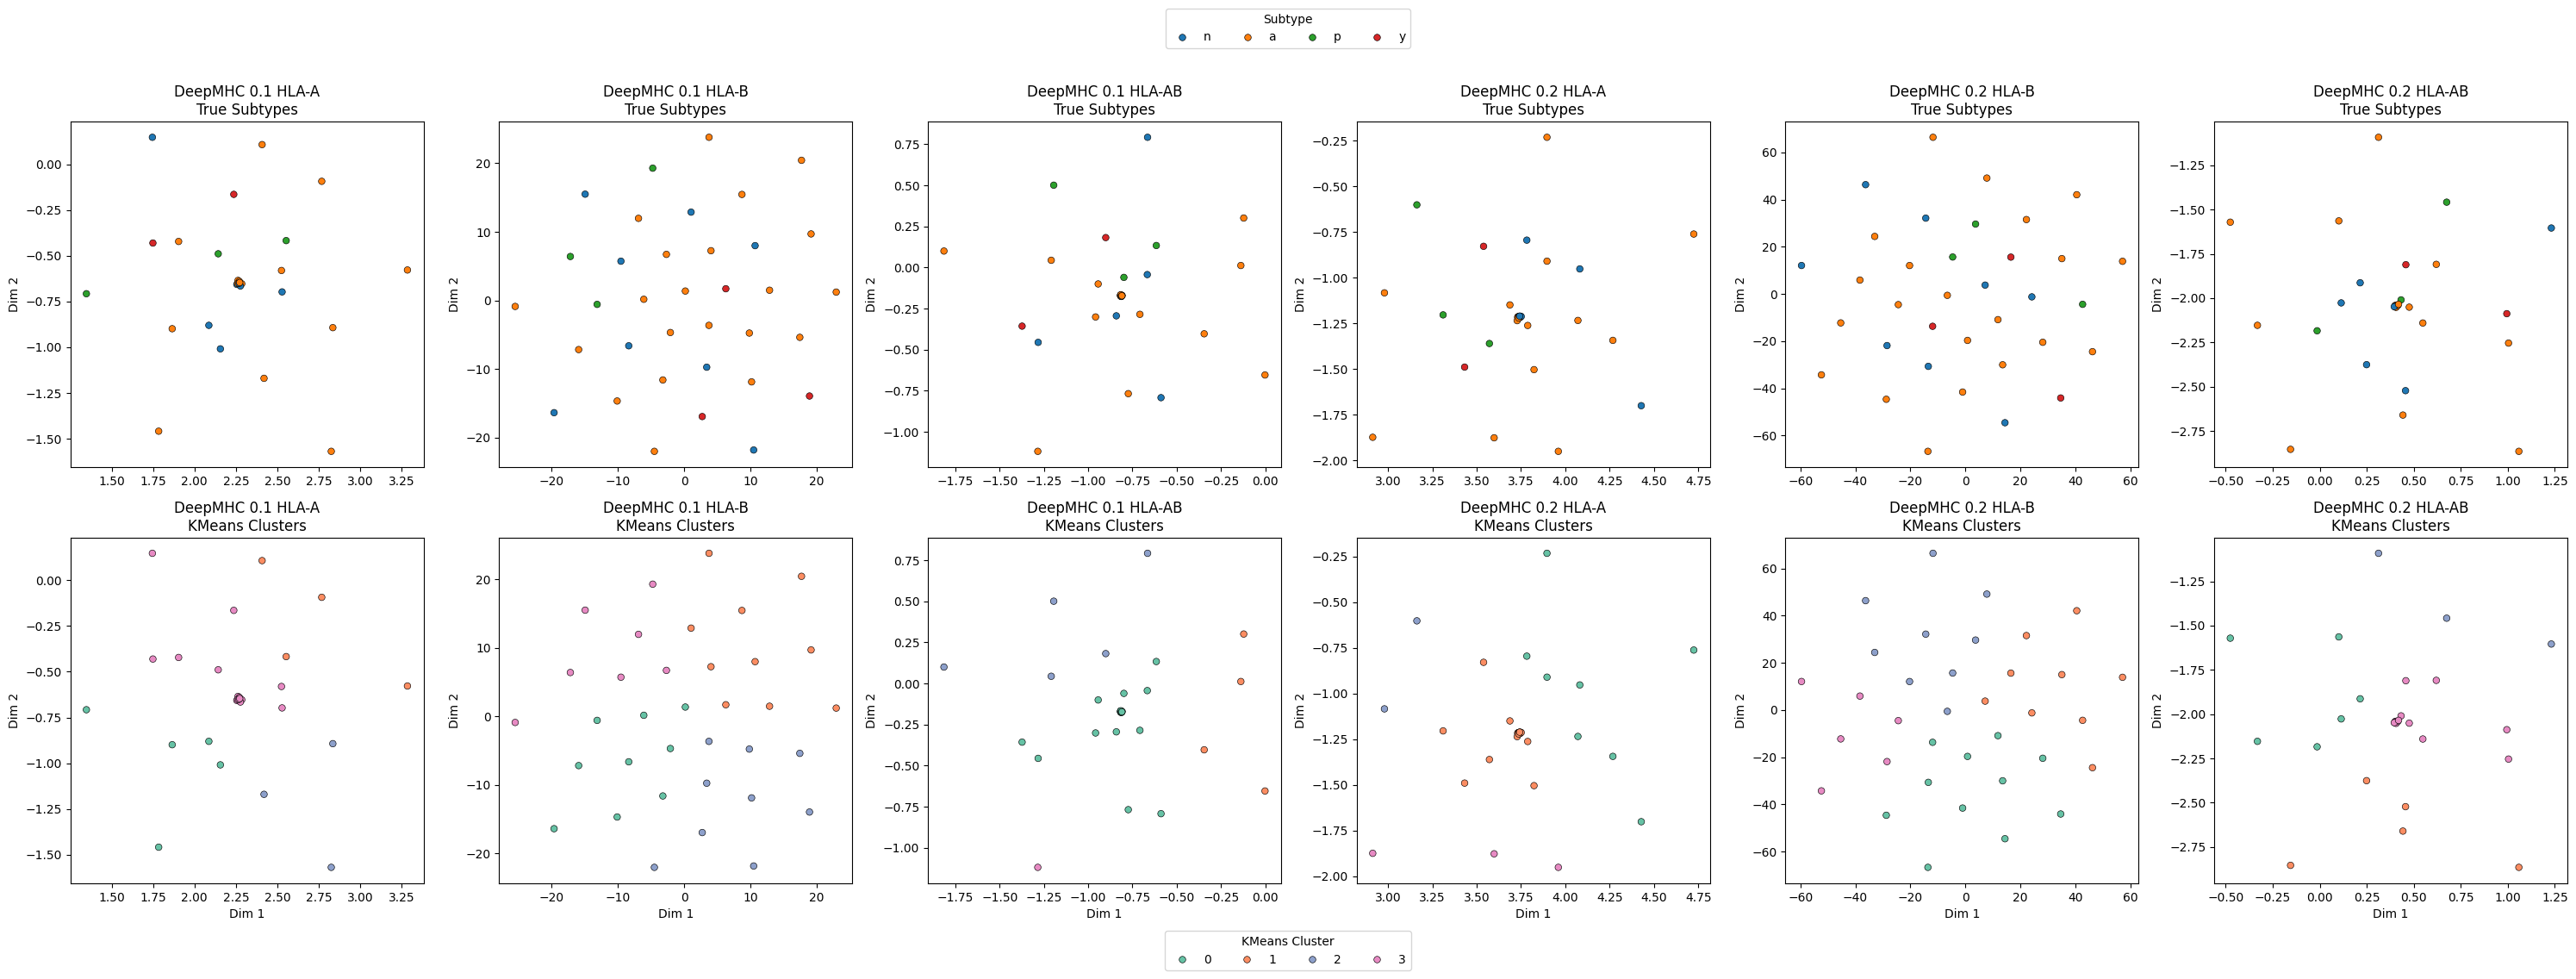

In [ ]:
plot_grid('tsne')


In [ ]:
# New code for Aim 3 significance

import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# chi-square
def run_chi_squared(true_labels, predicted_labels):
    table = pd.crosstab(true_labels, predicted_labels)
    chi2, p, dof, expected = chi2_contingency(table)

    print("Chi-squared Test Results")
    print("------------------------")
    print(f"Chi2 Statistic      : {chi2:.3f}")
    print(f"Degrees of Freedom  : {dof}")
    print(f"P-value             : {p:.3e}")
    print("Expected Frequencies:")
    print(expected)

    return chi2, p, table


# data with type of tumor status
subtype_path = "/content/drive/Shareddrives/BMI212/AIM2/Copy of subtype_mapping (for AIM 3).xlsx"
metadata_df = pd.read_excel(subtype_path, index_col=0)
metadata_df.index = metadata_df.index.str.replace(r'_.*$', '', regex=True)

# Filtering out status
met_info = metadata_df[['Met?']].dropna()


shared_ids = data_hla_AB_1.index.intersection(met_info.index)
X = data_hla_AB_1.loc[shared_ids]
y = met_info.loc[shared_ids]['Met?']

X_scaled = StandardScaler().fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Running chi-squared test
print("\n[1] Clustering vs. 'Met?' Status")
chi2_val, p_val, table = run_chi_squared(y, clusters)
print("\nContingency Table:\n", table)



map_new = pd.read_excel("/content/drive/Shareddrives/BMI212/AIM2/Copy of subtype_mapping (for AIM 3).xlsx", index_col=0)
map_old = pd.read_excel("/content/drive/Shareddrives/BMI212/AIM2/subtype_mapping.xlsx", index_col=0)

map_new.index = map_new.index.str.replace(r'_.*$', '', regex=True)
map_old.index = map_old.index.str.replace(r'_.*$', '', regex=True)


valid_met = map_new[['Met?']].dropna()
common_ids = valid_met.index.intersection(map_old.index)

met_status = valid_met.loc[common_ids]['Met?']
subtype_labels = map_old.loc[common_ids]['Subtype']


cross_tab = pd.crosstab(met_status, subtype_labels)
chi2_stat, p_subtype, df, exp = chi2_contingency(cross_tab)

# Output summary
print("\n[2] 'Met?' Status vs. Subtype")
print("--------------------------------")
print("Contingency Table:\n", cross_tab)
print(f"\nChi2 Statistic     : {chi2_stat:.3f}")
print(f"Degrees of Freedom : {df}")
print(f"P-value            : {p_subtype:.4e}")
print("Expected Counts:\n", exp)

if p_subtype < 0.05:
    print("Significant association (p < 0.05)")
else:
    print("No significant association (p ≥ 0.05)")